In [278]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing, linear_model, model_selection, metrics, datasets, base
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
import xgboost as xgb


In [2]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider



In [210]:
df=pd.read_csv(r'atp_data.csv')

In [211]:
df.head(10)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,1/3/2000,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
5,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Caratti C.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
6,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Berasategui A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
7,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Bastl G.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
8,2,Chennai,Gold Flake Open,1/3/2000,International,Outdoor,Hard,Semifinals,3,Hantschk M.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
9,2,Chennai,Gold Flake Open,1/3/2000,International,Outdoor,Hard,Semifinals,3,Golmard J.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


Variables of interest

Target Variable: Upset-1 if a lower ranked player beats a higher ranked player, 0 otherwise

Categorical vars: ["Series","Court","Surface","Round","Tournament",'Comment']

Numerical vars: ['WRank','LRank','Wsets','Lsets','Year','elo_rank']

Calculated numerical vars: 


In [212]:
#Rank_Delta=Winner Rank- Loser Rank so if Delta>0, that means the winner has a higher numerical rank and the match is an upset
def upset(row):
    if row['Rank_Delta']>0:
        return 1
    else:
        return 0

In [213]:
def clean_data(df):
    df = df.sort_values("Date")
    df["WRank"] = df["WRank"].replace(np.nan, 0)
    df["WRank"] = df["WRank"].replace("NR", 2000)
    df["LRank"] = df["LRank"].replace(np.nan, 0)
    df["LRank"] = df["LRank"].replace("NR", 2000)
    df["WRank"] = df["WRank"].astype(int)
    df["LRank"] = df["LRank"].astype(int)
    df["Wsets"] = df["Wsets"].astype(float)
    df['Wsets'] = df['Wsets'].replace(np.nan, 0.0)
    df["Lsets"] = df["Lsets"].replace("`1", 1)
    df["Lsets"] = df["Lsets"].astype(float)
    df['Lsets'] = df['Lsets'].replace(np.nan, 0.0)
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))
    df['Year'] = df['Date'].apply(lambda x: x.year)
    # new var: Rank_Delta
    df['Rank_Delta'] = df['WRank'] - df['LRank']
    df = df.sort_values("Date")
    df.reset_index(drop=True, inplace=True)
    return df

In [214]:
def make_confusion_matrix(model, x_test, y_test, class_labels,threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(x_test)[:, 1] >= threshold)
    c_matrix = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(c_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=class_labels,
           yticklabels=class_labels);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    return plt

In [215]:
def final_comparison(models, x_test, y_test):
    scores=pd.DataFrame()
    for model in models:
        predictions = (model.predict(x_test))
        accuracy=metrics.accuracy_score(y_test,predictions)
        precision=metrics.precision_score(y_test,predictions)
        recall=metrics.recall_score(y_test,predictions)
        roc=roc_auc_score(y_test, predictions)
        scores[str(model)]=[accuracy,precision,recall, roc]
    scores.index=['accuracy','precision','recall','roc']
    return scores

In [230]:
def plot_roc(model, x_test, y_test):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(x_test))
    plt.plot(fpr, tpr,lw=2)
    #plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve');
    print("ROC AUC score = ", metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
    return plt

In [276]:
def generate_coef_table(feature_names, model, model_type, top_x_features):
    coef_table = pd.DataFrame(list(feature_names),columns=['Variable']).copy()
    if model_type=='regression':
        feature_scores=model.coef_.transpose()

    elif model_type=='tree':
        feature_scores=model.feature_importances_

    coef_table.insert(len(coef_table.columns),"Coefs",feature_scores)
    coefficient_table= pd.concat([coef_table.sort_values('Coefs', ascending=False)[:int(top_x_features/2)], coef_table.sort_values('Coefs', ascending=False)[-int(top_x_features/2):]])
    
    # plot feature importance: NEED TO FIX
    #x_axis=range(0,len(coefficient_table.columns))
    #bar_graph=pyplot.bar(x_axis, list(coefficient_table['Coefs']))
    #bar_graph.xticks(x_axis, list(coefficient_table.columns))

    return coefficient_table

In [216]:
df=clean_data(df)
df['upset']=df.apply(lambda row: upset(row),axis=1)
target_var=df['upset']
cat_vars = ["Series","Court","Surface","Round","Tournament",'Comment']
cat_features=pd.get_dummies(df[cat_vars], drop_first=True)
numeric_vars=['Wsets','Lsets','Year','elo_winner','elo_loser']
numeric_features=df[numeric_vars]
all_features=pd.concat([numeric_features,cat_features],1)

C:\Users\emwang\AppData\Local\Temp/ipykernel_30560/2393790483.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  all_features=pd.concat([numeric_features,cat_features],1)


In [217]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target_var, test_size=0.20, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=list(X_train.columns))

In [123]:
print('Percent Upsets: {a}'.format(a=len(df[df['upset']==1])/len(df)))
print('Percent Expected: {a}'.format(a=len(df[df['upset']==0])/len(df)))

Percent Upsets: 0.3439205511317885
Percent Expected: 0.6560794488682115


In [218]:
lr = LogisticRegression(solver='liblinear', penalty = 'l2',random_state=42)
lr.fit(X_train_scaled, y_train)
predictions=lr.predict(X_test_scaled)
score=metrics.accuracy_score(y_test,predictions)
precision=metrics.precision_score(y_test,predictions)
recall=metrics.recall_score(y_test,predictions)

print(f1_score(lr.predict(X_test_scaled), y_test))
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.7236197872699645
0.7868159842883223
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      5824
           1       0.76      0.69      0.72      3118

    accuracy                           0.82      8942
   macro avg       0.80      0.79      0.79      8942
weighted avg       0.81      0.82      0.81      8942



In [ ]:
print(f1_score(lr.predict(X_test_scaled), y_test))
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, predictions))


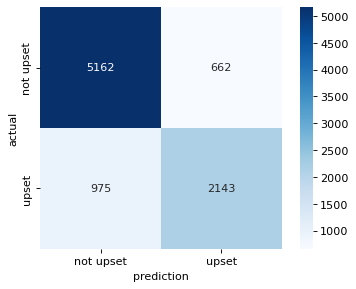

In [224]:
cm_plt=make_confusion_matrix(lr, X_test_scaled, y_test,class_labels=['not upset','upset'])
cm_plt.show()


ROC AUC score =  0.8929205265949574


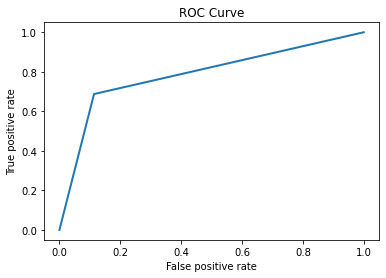

In [231]:
roc_curve=plot_roc(lr, X_test_scaled, y_test)
roc_curve.show()

### Testing the model parameters to deal with class imbalance

actually does worse....not sure why lol

In [138]:
lr_imbalanced = LogisticRegression(class_weight={1 : 1, 0 : 2}, solver='liblinear')
lr_imbalanced.fit(X_train_scaled, y_train)
predictions=lr_imbalanced.predict(X_test_scaled)

print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, predictions))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79      5824
           1       0.48      0.00      0.01      3118

    accuracy                           0.65      8942
   macro avg       0.56      0.50      0.40      8942
weighted avg       0.59      0.65      0.52      8942

0.500733731470582


### !Decision Tree Time!

In [239]:
from sklearn import tree
import graphviz 
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [156]:
pipe_steps=[('scaler', StandardScaler()),
          ('decsT', DecisionTreeClassifier(random_state=5, class_weight='balanced', min_samples_split=0.1))]

check_params={
                'decsT__max_leaf_nodes': list(range(5,12)),
                'decsT__criterion': ['gini','entropy'],
                'decsT__max_depth': np.arange(3,8)
            }
pipeline=Pipeline(pipe_steps)

In [157]:
create_grid=GridSearchCV(pipeline, param_grid=check_params, cv=4, verbose=1)
create_grid.fit(X_train, y_train)

print("Train score for %d fold CV := %3.2f" %(4, create_grid.score(X_train, y_train)))
print("Test score for %d fold CV := %3.2f" %(4, create_grid.score(X_test, y_test)))
print ("!!!! best fit parameters from GridSearchCV !!!!")
print (create_grid.best_params_)


Fitting 4 folds for each of 70 candidates, totalling 280 fits
Train score for 4 fold CV := 0.59
Test score for 4 fold CV := 0.58
!!!! best fit parameters from GridSearchCV !!!!
{'decsT__criterion': 'gini', 'decsT__max_depth': 4, 'decsT__max_leaf_nodes': 11}


In [290]:
clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth=50, max_leaf_nodes= 1000, min_impurity_decrease=0.01, random_state=65)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, predictions))
score=metrics.accuracy_score(y_test,predictions)
precision=metrics.precision_score(y_test,predictions)
recall=metrics.recall_score(y_test,predictions)



              precision    recall  f1-score   support

           0       0.82      0.89      0.86      5824
           1       0.76      0.64      0.70      3118

    accuracy                           0.80      8942
   macro avg       0.79      0.77      0.78      8942
weighted avg       0.80      0.80      0.80      8942

0.7662657759975753


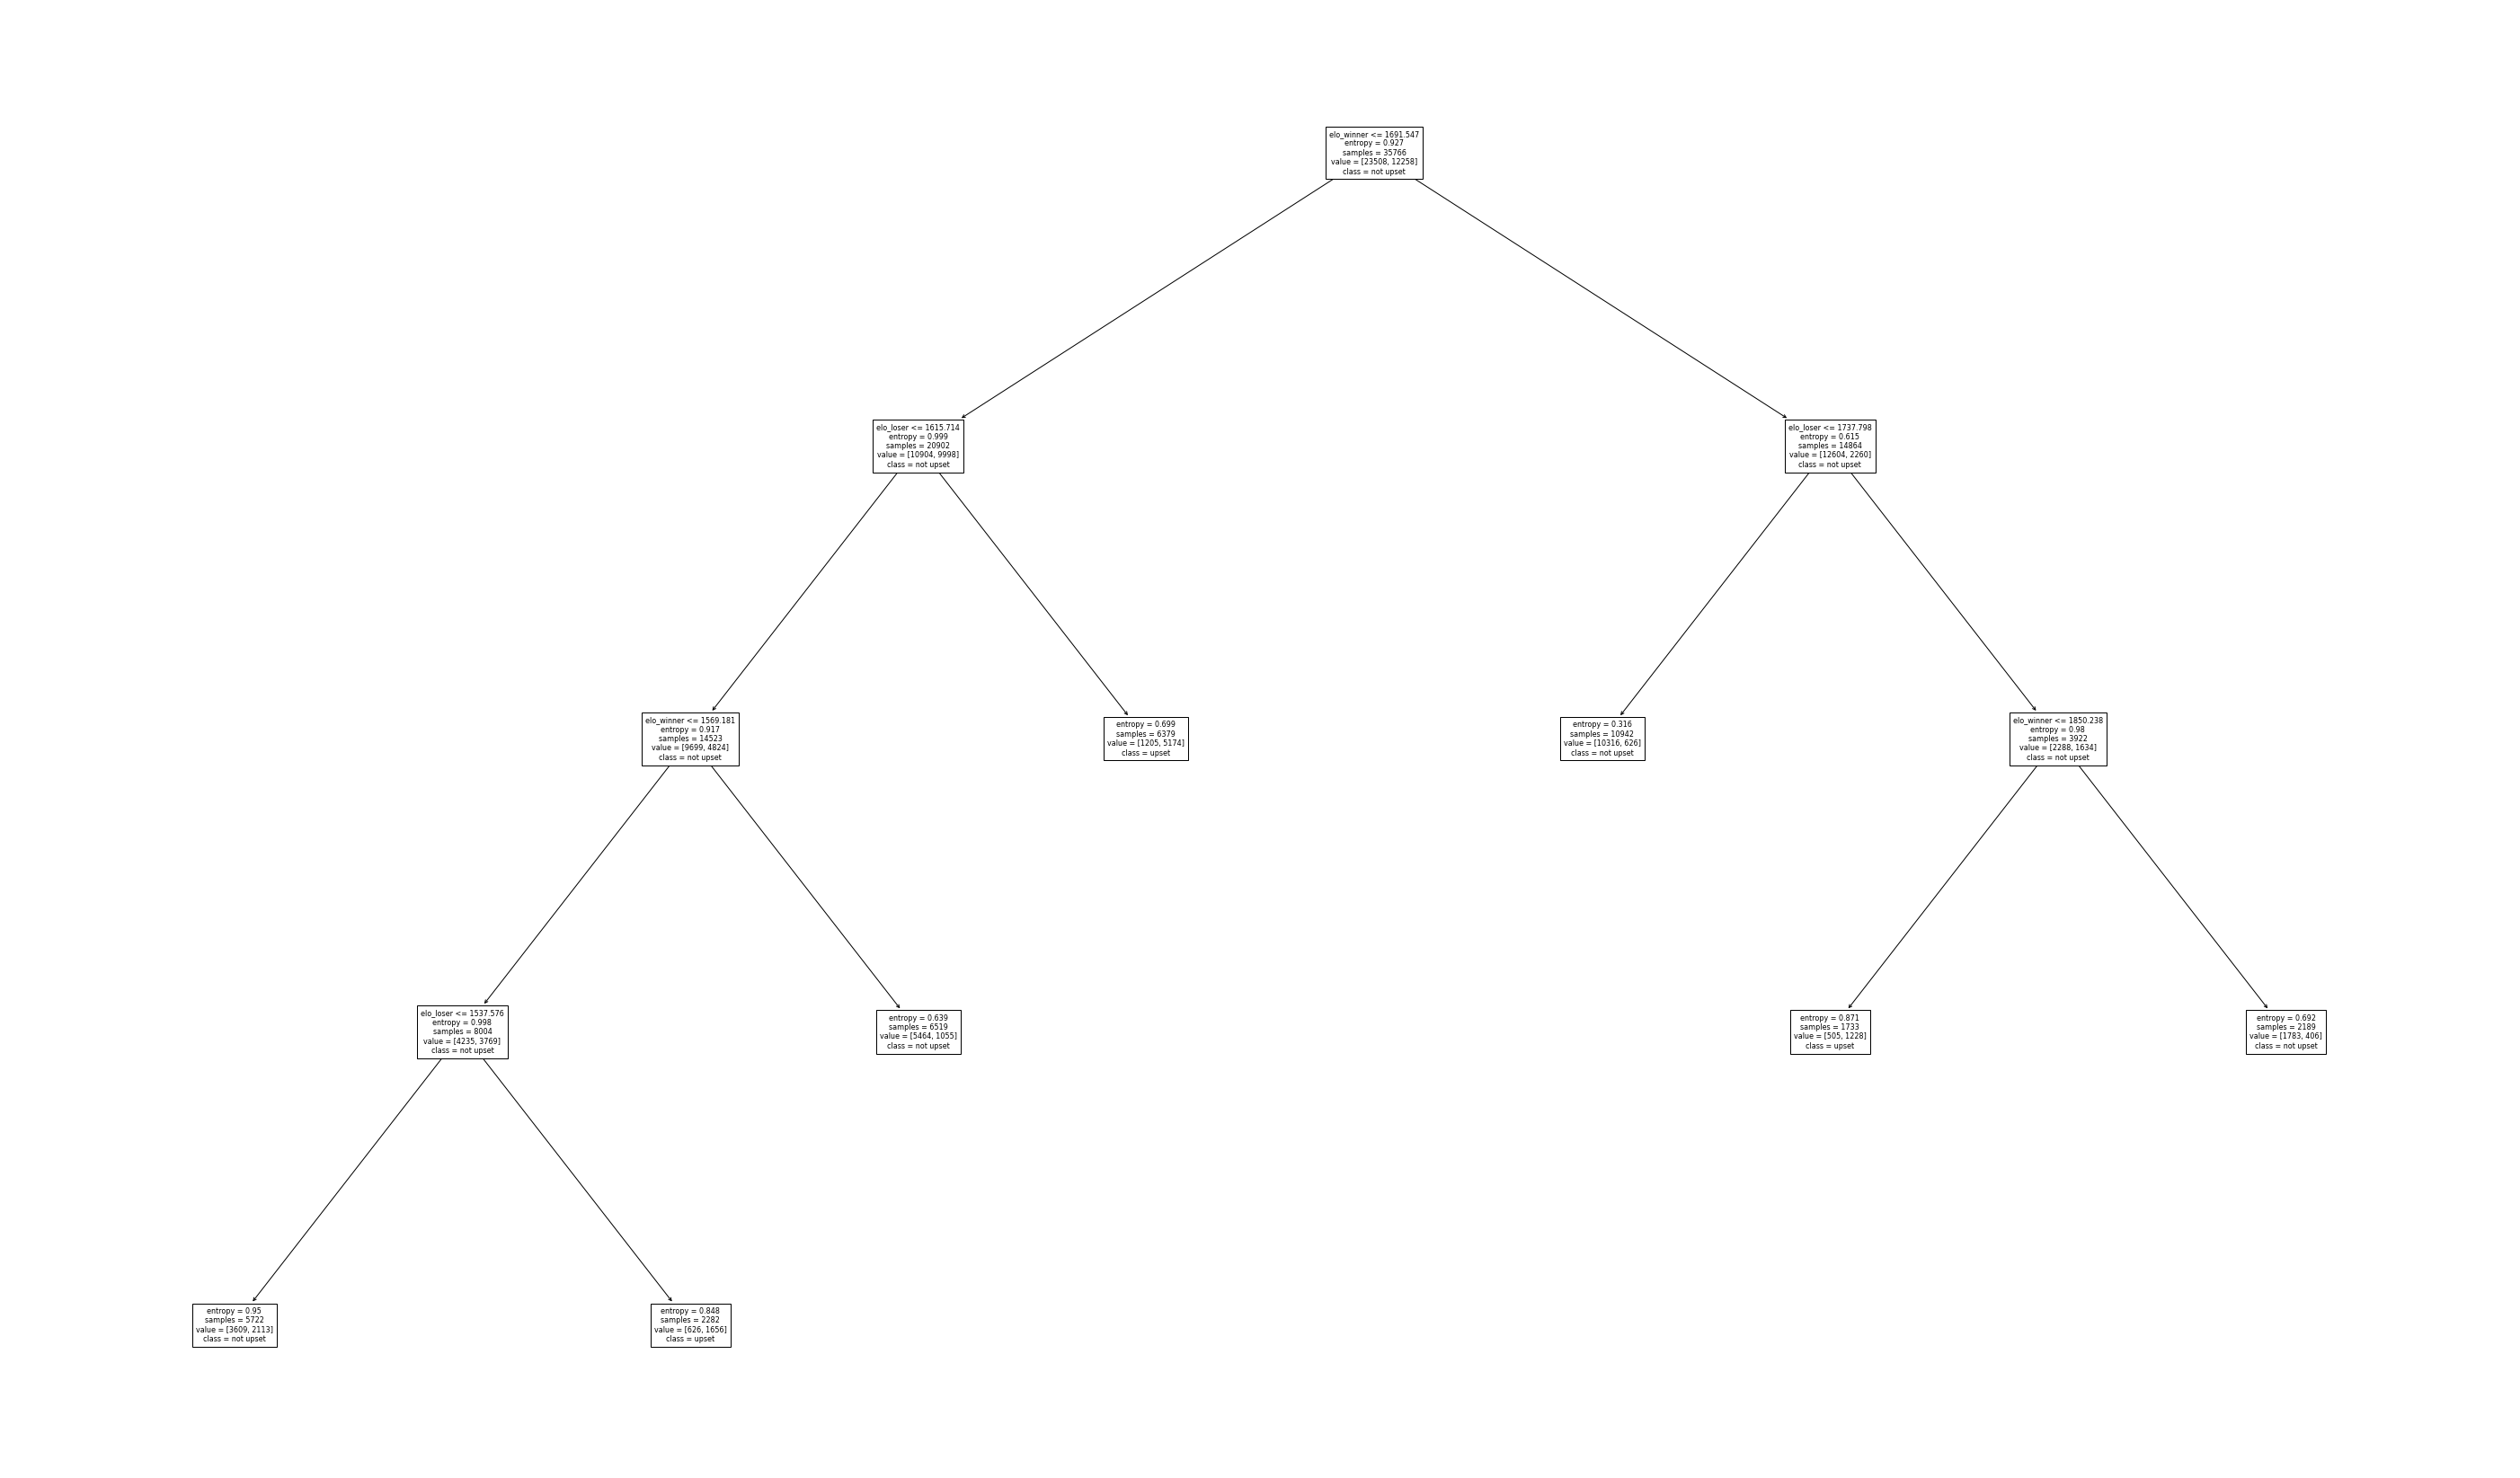

In [291]:
plt.figure(figsize=(50,30))
tree.plot_tree(clf,
               feature_names=list(X_train.columns),
               class_names=['not upset','upset'],
               fontsize=8)
plt.show()

In [241]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 65,
 'splitter': 'best'}

In [179]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 11,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [178]:
clf.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 4,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': 11,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'n_features_in_': 232,
 'n_features_': 232,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 232,
 'tree_': <sklearn.tree._tree.Tree at 0x262d90ca9d0>}

In [170]:
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, predictions))
score=metrics.accuracy_score(y_test,predictions)
precision=metrics.precision_score(y_test,predictions)
recall=metrics.recall_score(y_test,predictions)
print(recall)

              precision    recall  f1-score   support

           0       0.66      0.99      0.79      5824
           1       0.61      0.04      0.07      3118

    accuracy                           0.66      8942
   macro avg       0.64      0.51      0.43      8942
weighted avg       0.64      0.66      0.54      8942

0.512259989849791
0.03688261706221937


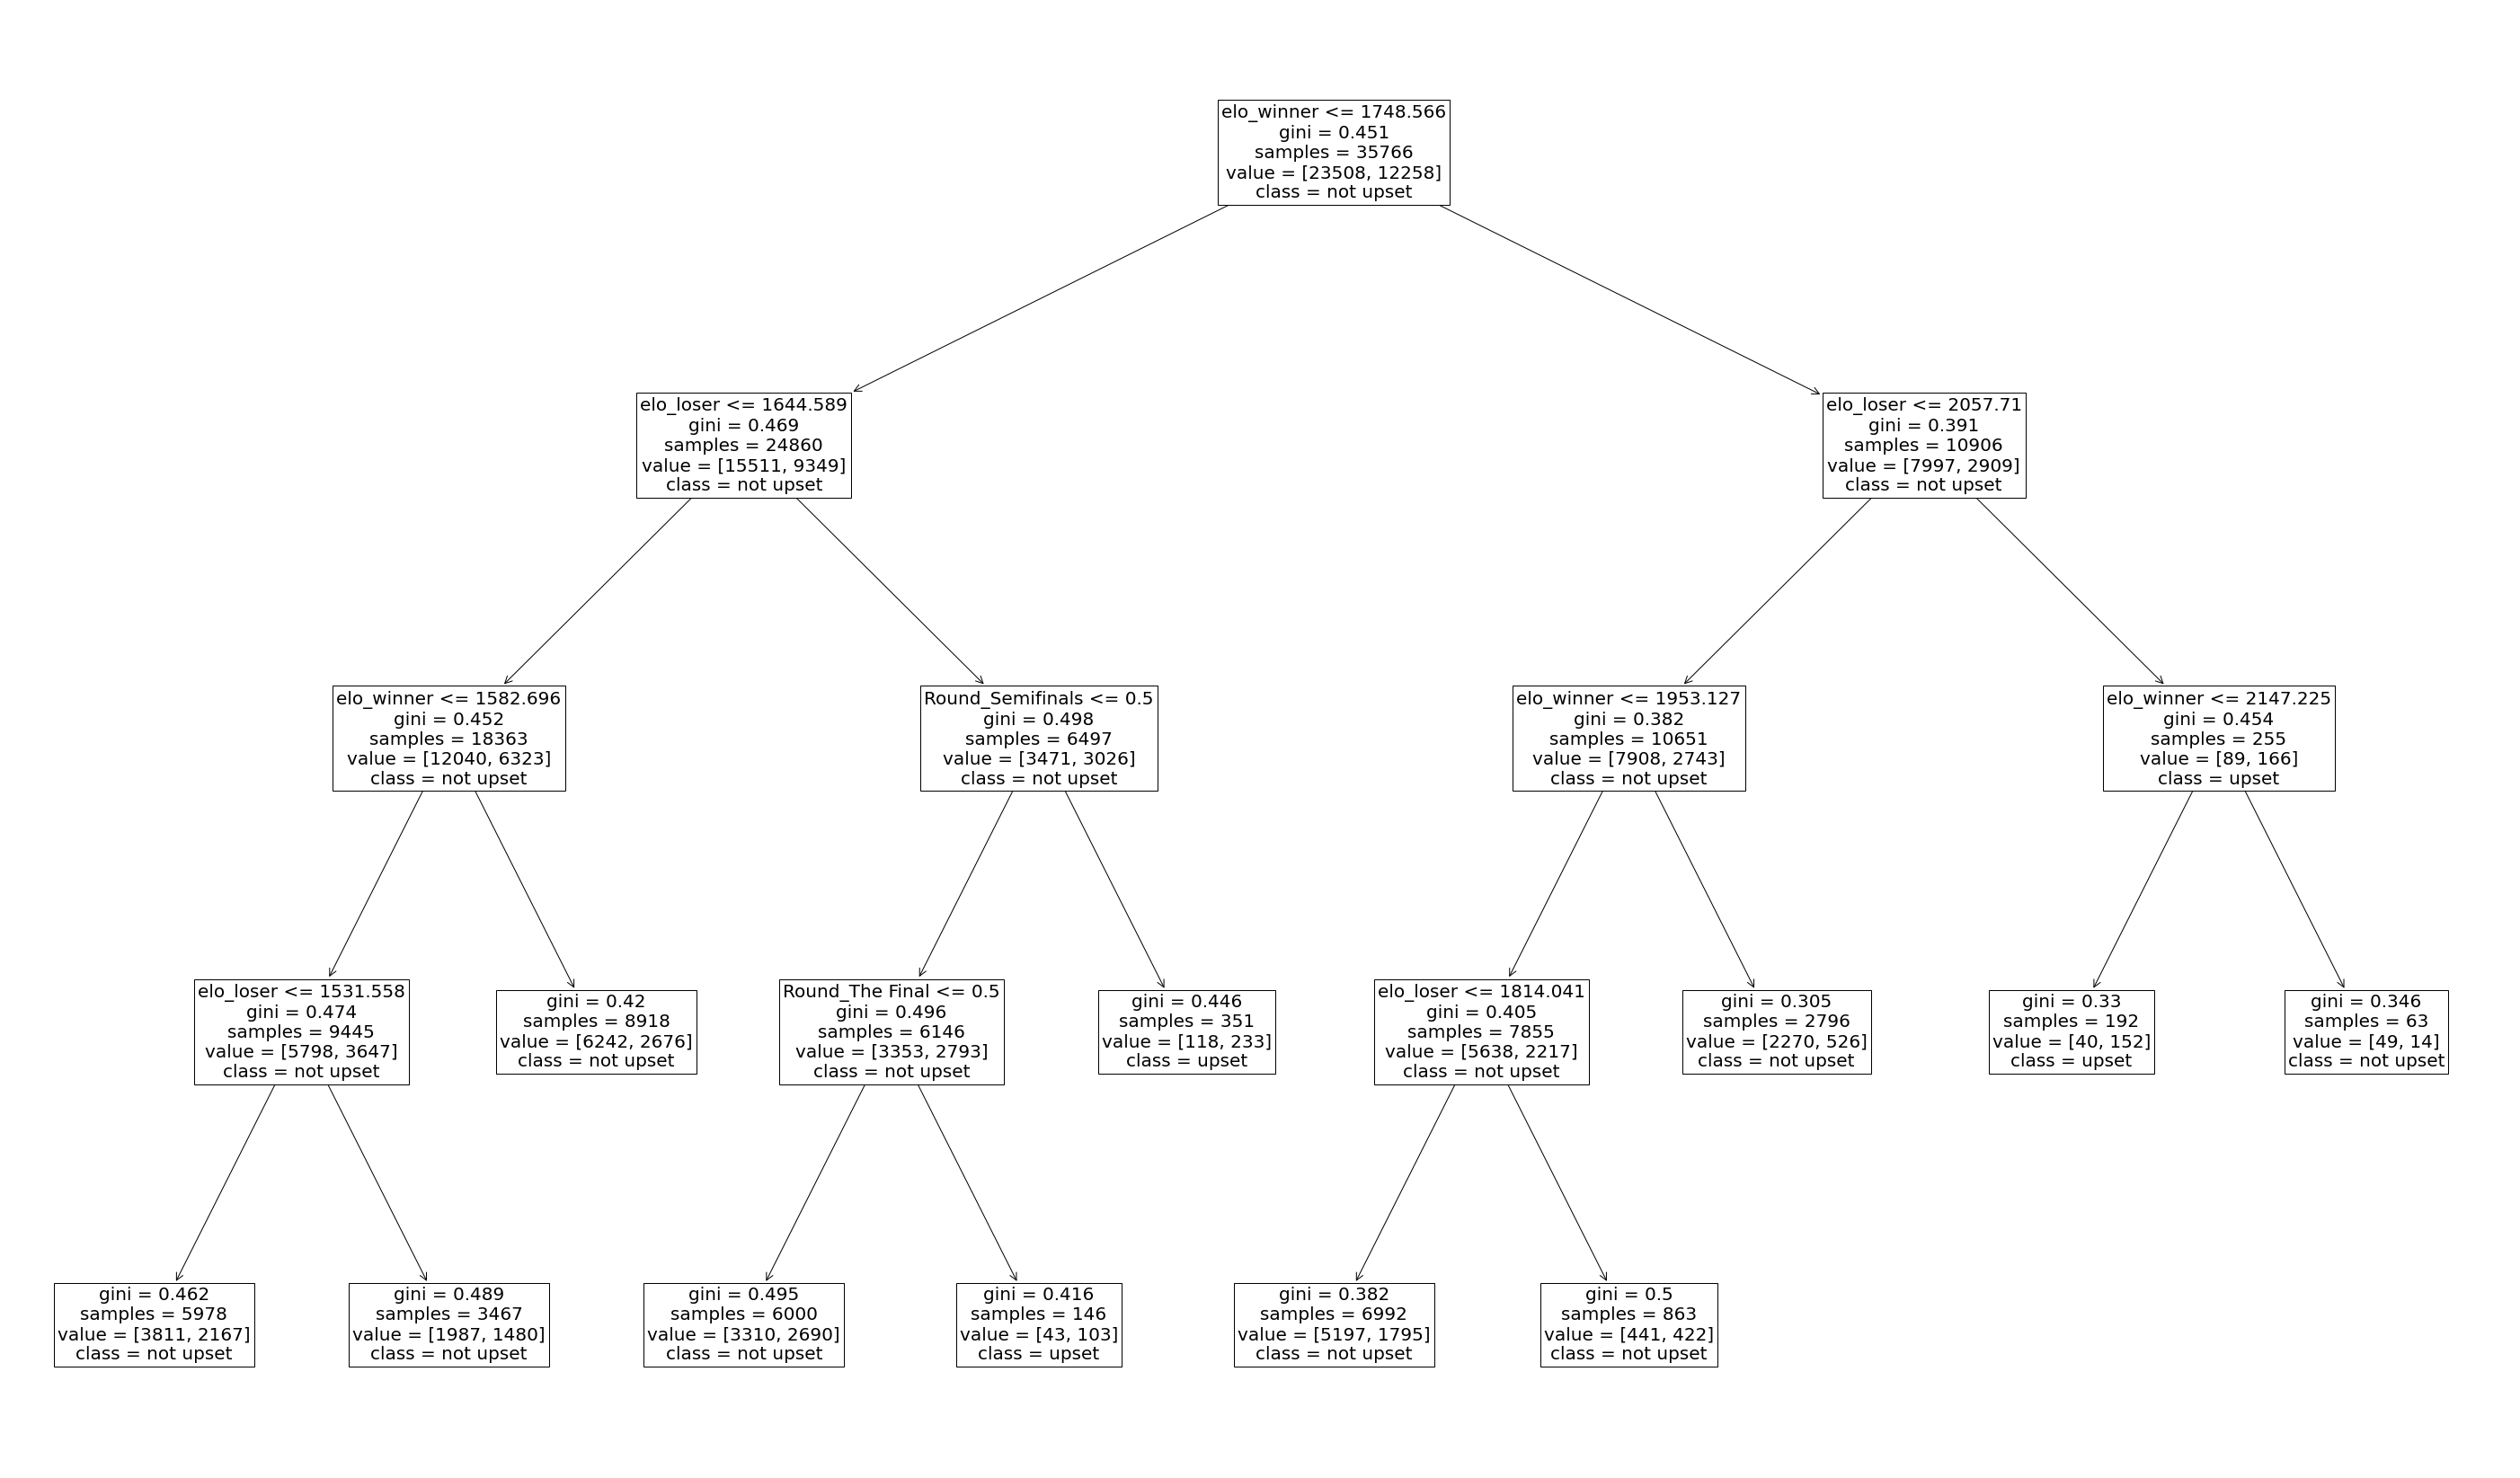

In [171]:
plt.figure(figsize=(50,30)) 
tree.plot_tree(clf,
               feature_names=list(X_train.columns),
               class_names=['not upset','upset'],
               fontsize=20)
plt.show()

In [161]:
clf.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': 4,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': 11,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'n_features_in_': 232,
 'n_features_': 232,
 'n_outputs_': 1,
 'classes_': array([0, 1], dtype=int64),
 'n_classes_': 2,
 'max_features_': 232,
 'tree_': <sklearn.tree._tree.Tree at 0x262dddab8f0>}

In [ ]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=65, max_leaf_nodes=29)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)

In [280]:
xgb_model = xgb.XGBClassifier(tree_method= random_state = 42)
xgb_model.__dict__

{'use_label_encoder': False,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'max_depth': None,
 'max_leaves': None,
 'max_bin': None,
 'grow_policy': None,
 'learning_rate': None,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': None,
 'sampling_method': None,
 'colsample_bytree': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'random_state': 42,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': None,
 'gpu_id': None,
 'validate_parameters': None,
 'predictor': None,
 'enable_categorical': False,
 'max_cat_to_onehot': None,
 'eval_metric': None,
 'early_stopping_rounds': None,
 'callbacks': None}

In [288]:
xgb_model = xgb.XGBClassifier(tree_method='hist', random_state = 42)
#xgb_model.fit(X_train,y_train)
check_params={
                'n_estimators': list(range(1000, 2500,500))
                ,'max_depth': np.arange(8,12)
                , 'eta': [0.0,0.5,1]
                , 'subsample': [0.5, 1]
                , 'colsample_bytree': [0.5, 1]
             }

In [289]:
create_grid=GridSearchCV(xgb_model, param_grid=check_params, cv=4, verbose=10)
create_grid.fit(X_train, y_train)

print("Train score for %d fold CV := %3.2f" %(4, create_grid.score(X_train, y_train)))
print("Test score for %d fold CV := %3.2f" %(4, create_grid.score(X_test, y_test)))
print ("!!!! best fit parameters from GridSearchCV !!!!")
print (create_grid.best_params_)


Fitting 4 folds for each of 144 candidates, totalling 576 fits
[CV 1/4; 1/144] START colsample_bytree=0.5, eta=0.0, max_depth=8, n_estimators=1000, subsample=0.5
[CV 1/4; 1/144] END colsample_bytree=0.5, eta=0.0, max_depth=8, n_estimators=1000, subsample=0.5;, score=0.657 total time=13.4min
[CV 2/4; 1/144] START colsample_bytree=0.5, eta=0.0, max_depth=8, n_estimators=1000, subsample=0.5


KeyboardInterrupt: 

--------------END--------------